# 基于Eecode-Decoder框架的Seq2Seq模型

本文将会通过一个简单的示例来介绍如何在`Keras`中定义一个基于encoder-decoder框架的seq2seq模型  
本文的代码可以在[github](https://github.com/snowhyzhang/yukino/blob/master/deep_learning/encoder-decoder_seq2seq_model.ipynb)上找到

encoder-decoder框架是常见的seq2seq模型框架之一，本文将要实现的模型架构如下

![seq2seq](decoder-encoder_seq2seq_model.png)

- 生成示例数据

我们将会生成一个长度为8的列表作为输入，其中每个元素为1到30内的整数，然后将前3位的数字倒序作为输出，例如输入\[1, 2, 3, 4, 5, 6, 7, 8\]，输出为\[3, 2, 1\]

In [1]:
import numpy as np

In [2]:
# 整数范围
N_FEATURE = 30 + 1
# 列表长度
N_INPUT_LENGTH = 8
# 输出长度
N_OUTPUT_LENGTH = 3

定义一个数据生成器，生成器将会输返回三个序列，分别为encoder的输入，decoder的输入，以及最终的输出

In [3]:
from keras.utils import to_categorical

# 数据生成器
def generate_data(data_size):
    encode_input, decode_input, output = [], [], []
    for _ in range(data_size):
        # 随机产生8个1到30内的整数，作为encoder输出
        source = np.random.randint(1, N_FEATURE, size=N_INPUT_LENGTH)
        # decoder的输入
        target_in = np.append([0], target_out[:-1])
        # 最终输出
        target_out = source[:N_OUTPUT_LENGTH][::-1]
        
        # 将列表转为one-hot编码
        src_encoded = to_categorical(source, num_classes=N_FEATURE)
        tar_in_encoded = to_categorical(target_in, num_classes=N_FEATURE)
        tar_out_encoded = to_categorical(target_out, num_classes=N_FEATURE)
        
        encode_input.append(src_encoded)
        decode_input.append(tar_in_encoded)
        output.append(tar_out_encoded)
    
    return np.array(encode_input), np.array(decode_input), np.array(output)

# 解码输出
def decode_vector(vec):
    return [np.argmax(v) for v in vec]

Using TensorFlow backend.


- 定义模型

In [4]:
from keras import layers
from keras.models import Model

HIDDED_SIZE = 128

In [5]:
# encoder层
encoder_inputs = layers.Input(shape=(None, N_FEATURE))
encoder = layers.LSTM(HIDDED_SIZE, return_state=True)
# 这里只需要保存encoder输出的hidden state和cell state，作为decoder层中的LSTM的初始状态
_, state_h, state_c = encoder(encoder_inputs)
encoder_state = [state_h, state_c]

# decoder层
decoder_inputs = layers.Input(shape=(None, N_FEATURE))
decoder_lstm = layers.LSTM(HIDDED_SIZE, return_sequences=True, return_state=True)
# 将encoder的hidden state和cell state作为LSTM的初始状态
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_state)

# 全链层，softmax作为激活函数
decoder_dense = layers.Dense(N_FEATURE, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

使用`Keras`的`plot_model`方法来查看模型结构

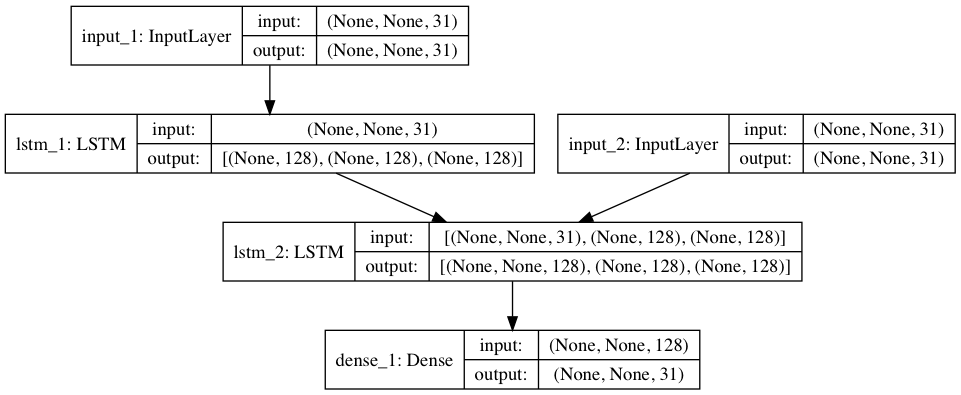

In [6]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, 'seq_model.png', show_shapes=True)
Image(filename='seq_model.png')

- 定义推断模型

encoder模型，作为编码器

In [7]:
encoder_model = Model(encoder_inputs, encoder_state)

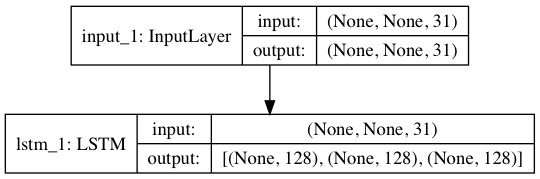

In [8]:
plot_model(encoder_model, 'seq_encoder_model.png', show_shapes=True)
Image(filename='seq_encoder_model.png')

decoder模型，作为解码器

In [9]:
decoder_state_input_h = layers.Input(shape=(HIDDED_SIZE, ))
decoder_state_input_c = layers.Input(shape=(HIDDED_SIZE, ))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

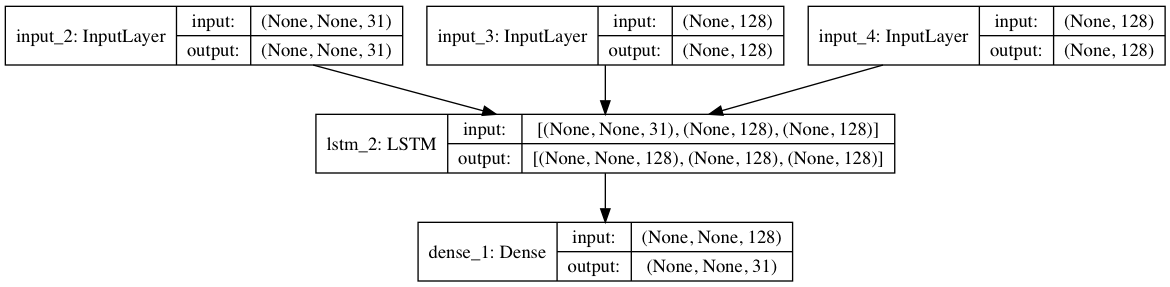

In [10]:
plot_model(decoder_model, 'seq_decoder_model.png', show_shapes=True)
Image(filename='seq_decoder_model.png')

- 推断函数

In [11]:
def predict_seq(source):
    # 从编码器中得到state
    state = encoder_model.predict(source)
    target_seq = np.array([0.0 for _ in range(N_FEATURE)]).reshape(1, 1, N_FEATURE)
    output = []
    for _ in range(N_OUTPUT_LENGTH):
        # 将输入与状态输入到解码器中
        y_pred, h, c = decoder_model.predict([target_seq] + state)
        output.append(y_pred[0, 0, :])
        state = [h, c]
        target_seq = y_pred
    return np.array(output)

自定义一个判断整个seq的准确率函数

In [12]:
import keras.backend as K

def seq_acc(y_true, y_pred):
    total_count = K.shape(y_true)[0]
    arr_pred = K.one_hot(K.argmax(y_pred, axis=2), num_classes=N_FEATURE)
    correct = K.all(K.equal(y_true, arr_pred), axis=[2, 1])
    correct_count = K.sum(K.cast(correct, dtype='int32'))
    correct_rate = correct_count / total_count
    
    return correct_rate

- 训练模型

生成50000个数据作为训练数据集

In [13]:
source, target_in, target_out = generate_data(50000)
source.shape, target_in.shape, target_out.shape

((50000, 8, 31), (50000, 3, 31), (50000, 3, 31))

In [14]:
model.compile('adam', lexpoross='categorical_crossentropy', metrics=[seq_acc])

In [15]:
model.fit([source, target_in], target_out, 
          epochs=2, batch_size=128)

Epoch 1/2
50000/50000 [==============================] - 28s 563us/step - loss: 1.1397 - seq_acc: 0.2235
Epoch 2/2
50000/50000 [==============================] - 31s 622us/step - loss: 0.0580 - seq_acc: 0.9765


最后随机生成些数据来看下结果

In [16]:
for _ in range(10):
    X1, X2, y = generate_data(1)
    y_pred = predict_seq(X1)
    print('X@%s\ty@%s\ty_pred@%s' % (decode_vector(X1[0]), decode_vector(y[0]), decode_vector(y_pred)))

X@[6, 14, 8, 14, 5, 13, 4, 24]	y@[8, 14, 6]	y_pred@[8, 14, 6]
X@[13, 10, 16, 3, 17, 29, 1, 17]	y@[16, 10, 13]	y_pred@[16, 10, 13]
X@[8, 23, 22, 11, 26, 25, 14, 15]	y@[22, 23, 8]	y_pred@[22, 23, 8]
X@[5, 29, 19, 3, 22, 3, 8, 30]	y@[19, 29, 5]	y_pred@[19, 29, 5]
X@[9, 7, 23, 26, 8, 14, 6, 17]	y@[23, 7, 9]	y_pred@[23, 7, 9]
X@[6, 16, 29, 12, 15, 15, 24, 13]	y@[29, 16, 6]	y_pred@[29, 16, 6]
X@[8, 10, 25, 9, 6, 9, 25, 23]	y@[25, 10, 8]	y_pred@[25, 10, 8]
X@[20, 16, 30, 15, 15, 6, 22, 15]	y@[30, 16, 20]	y_pred@[30, 16, 20]
X@[27, 1, 7, 27, 24, 15, 12, 15]	y@[7, 1, 27]	y_pred@[7, 1, 27]
X@[2, 21, 16, 20, 29, 28, 20, 5]	y@[16, 21, 2]	y_pred@[16, 21, 2]
